# Quantify Papillary Muscle Hypertrophy

### Get Files

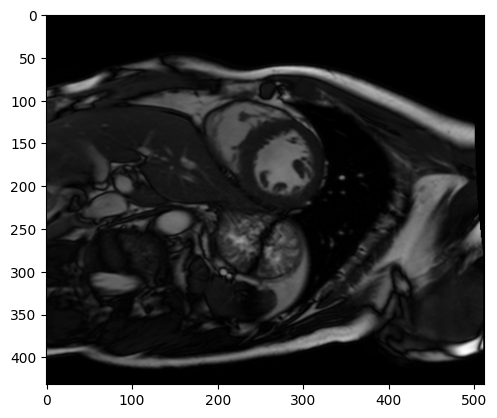

In [2]:
from glob import glob
import matplotlib.pyplot as plt
import napari
import nibabel as nib

# view image
search = glob('../data/fazit/all_scans/*.nii.gz')
image = nib.load(search[0]).get_fdata()
plt.imshow(image[:, :, 6, 0], cmap='Grays_r')

# napari.view_image(image.T);

## Quantify PMs
### All Scans
FaZiT images have very different pixel sizes, which causes low segmentation quality in some cases. The functions will print a warning, if the pixel sizes are very different from eachother, but will not omit the images from analysis.

In [3]:
from glob import glob
import matplotlib.pyplot as plt
import nibabel as nib

# select template 

template = nib.load(glob('../data/fazit/all_scans/6279*.nii.gz')[0]).get_fdata()
template = template[130:230, 210:310, 6, :]

print(template.shape)

# plot = plt.imshow(template[:, :, 0], cmap='Grays_r')
# plt.colorbar(plot)

(100, 100, 25)


Fabry patients:	 43
Cropping unsuccessful. Shape is (105, 102, 25) but expected to be (105, 105, 25)
Measurement of Fabry patient image 3589-2023_05_23 failed. This image is omitted from further analysis.
Measurement of Fabry patient image 4497-2023_08_07 failed. This image is omitted from further analysis.
Measurement of Fabry patient image 8893-2023_01_31 failed. This image is omitted from further analysis.
Processing Fabry patient 9524-2023_02_21 (43/43)...
Done.                                  


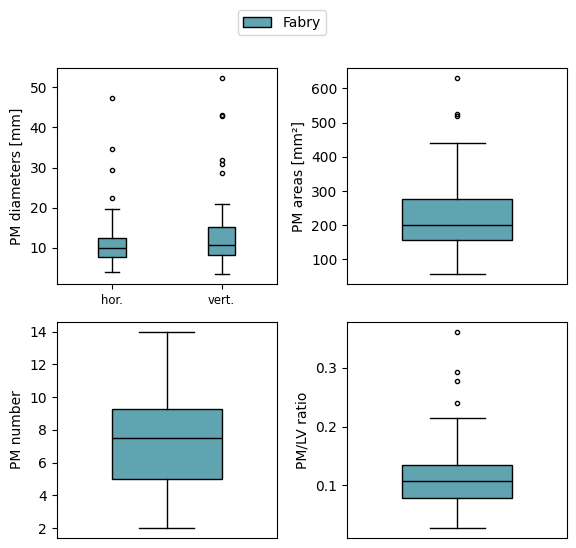

In [ ]:
from lc_functions import quantify_pms

# select input files
nifti_list = glob('../data/fazit/all_scans/*.nii.gz')

# quantify pms in all scans (includes scans that don't work well)
measurements, segmentations = quantify_pms('../data/fazit/all_scans/*.nii.gz', template_array=template, show_segmentations=False)

In [ ]:
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import patheffects
import os
import lc_functions as pmf

selected = [file.removesuffix('.nii.gz') for file in glob('../data/fazit/selected/*.nii.gz')]

def plot_segmentation_mod(imgs, names, pms, bps, show_bloodpool):
    '''
    plot segmented papillary uscles and optionally blood pool. creates correct number of subplots for any number of images

    arguments: 
        imgs:           list of arrays of cropped CMR images
        names:          list of names for the created subplots
        pms:            list of arrays of papillary muscle segmentations
        bps:            list of contours of blood pools
        show_bloodpool: if True, bloodpool segmentation is shown as orange contour in the diagnostic plot
    '''
    
    # automatically calculate nrows and ncols
    nimgs = len(imgs)
    if nimgs <= 100:     # only plot first n images
        nplots = nimgs
    else:
        nplots = 100
        print('Only the first', nplots, 'are plotted.')

    # ncols = 10
    ncols = 6
    if nplots <= ncols:
        ncols = nplots
        nrows = 1

    nrows = nplots // ncols
    if nplots % ncols != 0:
        nrows +=1 
    if nrows == 0:
        nrows = 1

    selected = [os.path.basename(file).removesuffix('.nii.gz') for file in glob('../data/fazit/selected/*.nii.gz')]

    # plot results
    plt.subplots(nrows, ncols, figsize=(ncols*1.9, nrows*2.2))
    for n in range(0, nplots):
        plt.subplot(nrows, ncols, n+1)

        plt.imshow(imgs[n], cmap='gray')
        if show_bloodpool:
            for contour in bps[n]:
                try:
                    plt.plot(contour[:, 1], contour[:, 0], color='orange', lw=1)
                except:
                    pass
        plt.imshow(pms[n], cmap=pmf.binary_cmap('red'), alpha=0.4)

        plt.title(names[n], fontsize='medium')
        plt.yticks([])
        plt.xticks([])

        if names[n].split('\n')[0] not in selected:
            txt = plt.gca().annotate('x', xy=(0.05, 0.95), xytext=(0, 0), xycoords='axes fraction', textcoords='offset points', ha='center', va='center',
                               fontsize=10, fontweight='bold', color='white')
            txt.set_path_effects([patheffects.withStroke(linewidth=2, foreground='black')])
    
    if nplots < nrows*ncols:
        for n in range(0, nrows*ncols-nplots+1):
            plt.subplot(nrows, ncols, nplots+n)
            plt.gca().set_axis_off()

    plt.tight_layout()
    plt.show()

In [6]:
# make figure of all segmentations for thesis

omit = [17, 31]      ## leave out images with different pixel sizes
sorted = dict()
for key in segmentations.keys():
    sorted[key] = [s for i, s in enumerate(segmentations[key]) if i not in omit]

# plot_segmentation_mod(sorted['imgs'], sorted['names'], sorted['pms'], sorted['bpconts'], show_bloodpool=True)

### Compare Longitudinal Data

Fabry patients:	 29
Processing Fabry patient 9402-2023_10_24 (29/29)...
Done.                                  


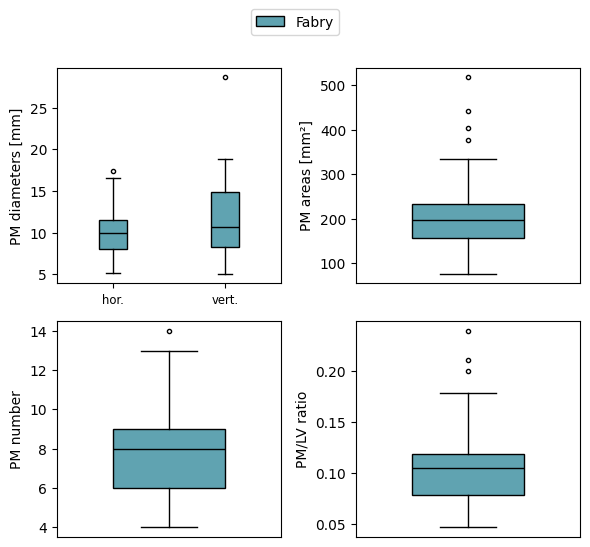

In [ ]:
from datetime import datetime as dt
from glob import glob
import nibabel as nib
import pandas as pd
import os

from lc_functions import quantify_pms

# quantify only selected scans

template = nib.load(glob('../data/fazit/all_scans/6279*.nii.gz')[0]).get_fdata()
template = template[130:230, 210:310, 6, :]

measurements, segmentations = quantify_pms('../data/fazit/selected/*.nii.gz', template_array=template, show_segmentations=False)

pd.DataFrame(measurements).to_csv('../results/measurements.csv', index=False)

# get patient codes and dates from filenames
patients = [os.path.basename(name).split('-')[0] for name in segmentations['names']]
dates = [dt.strptime(os.path.basename(name).split('-')[1].split('\n')[0].removesuffix('.nii.gz'), '%Y_%m_%d') for name in segmentations['names']]

diff = {}           # gets filled with number of days between 1st scan and 2nd, 3rd, ... scan
index_list = []     # gets filled with indices of measurements in areas list
sorted_m = {}       # gets filled with measurements sorted by patient
for i, patient in enumerate(set(patients)):
    if patients.count(patient) > 1:
        indices = [i for i, x in enumerate(patients) if x == patient]     # list of indices of this patient code
        index_list.append(indices)
        d = []
        for i in indices:
            d.append(abs(dates[i] - dates[indices[0]]).days)
        diff[patient] = d

        for key in measurements.keys():
            if key not in sorted_m.keys():
                sorted_m[key] = {}
            sorted_m[key][patient] = [measurements[key][i] for i in indices]

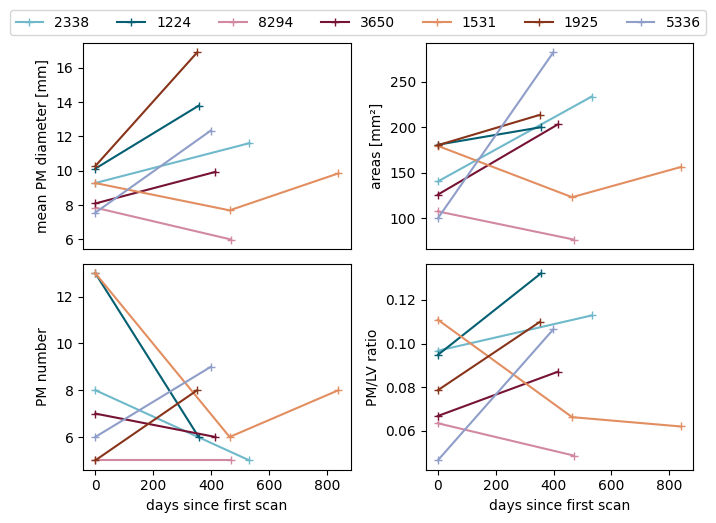

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from lc_functions import thesis_colors

colors = thesis_colors('ld')

fig, _ = plt.subplots(2, 2, figsize=(7, 5))

for i in range(len(diff)):
    patient = list(diff.keys())[i]

    # plot diameters
    plt.subplot(2, 2, 1)
    tps = [[sorted_m[key][patient][i] for key in ['hdiam1', 'hdiam2', 'vdiam1', 'vdiam2']] for i in range(len(sorted_m['hdiam1'][patient]))]
    means = [np.mean(tp) for tp in tps]
    plt.plot(diff[patient], means, marker='+', color=colors[i], label=patient)
    plt.xticks([])
    plt.ylabel('mean PM diameter [mm]')

    # plot remaining metrics
    labels = ['areas [mm²]', 'PM number', 'PM/LV ratio']
    for n, m in enumerate(['area', 'num', 'pm/lv ratio']):
        plt.subplot(2, 2, n+2)
        plt.plot(diff[patient], sorted_m[m][patient], marker='+', color=colors[i])
        if n == 0:
            plt.xticks([])
        else:
            plt.xlabel('days since first scan')
        plt.ylabel(labels[n])

fig.legend(bbox_to_anchor=(0.5, 1.05), loc='upper center', ncols=7)
plt.tight_layout()

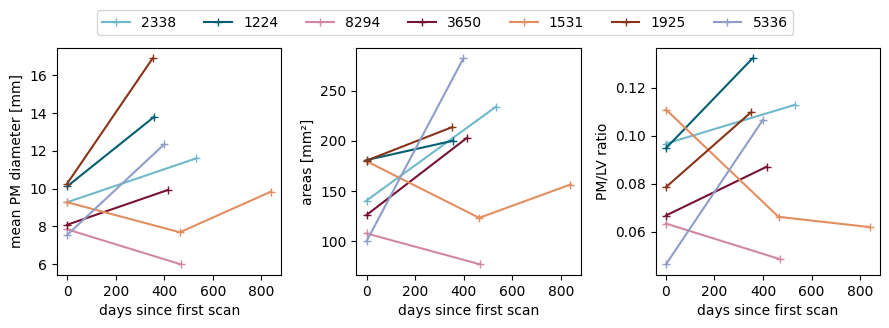

In [ ]:
## without PM number

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from lc_functions import thesis_colors

# define ibm_cmap for 

# ibm_colors = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']
# cmap = mpl.colors.LinearSegmentedColormap.from_list('custom', colors)
# cmp_colors = cmap(np.linspace(0, 1, len(index_list)))   # pick necessary number of colors from cmap
cmp_colors = mpl.colormaps['tab20'](np.linspace(0, 1, 20))[:len(index_list)]
colors = thesis_colors('ld')

fig, _ = plt.subplots(1, 3, figsize=(9, 3))

for i in range(len(diff)):
    patient = list(diff.keys())[i]

    # plot diameters
    plt.subplot(1, 3, 1)
    tps = [[sorted_m[key][patient][i] for key in ['hdiam1', 'hdiam2', 'vdiam1', 'vdiam2']] for i in range(len(sorted_m['hdiam1'][patient]))]
    means = [np.mean(tp) for tp in tps]
    # mins = [means[i]-np.min(tp) for i, tp in enumerate(tps)]  ## for yerr
    # maxs = [np.max(tp)-means[i] for i, tp in enumerate(tps)]
    # plt.errorbar(diff[patient], means, yerr=[mins, maxs], color=cmp_colors[i], label=patient)
    plt.plot(diff[patient], means, marker='+', color=colors[i], label=patient)
    plt.xlabel('days since first scan')
    # plt.xticks([])
    plt.ylabel('mean PM diameter [mm]')

    # plot remaining metrics
    # labels = ['areas [mm²]', 'PM number', 'PM/LV ratio']
    labels = ['areas [mm²]', 'PM/LV ratio']
    for n, m in enumerate(['area', 'pm/lv ratio']):
        plt.subplot(1, 3, n+2)
        plt.plot(diff[patient], sorted_m[m][patient], marker='+', color=colors[i])
        plt.xlabel('days since first scan')
        plt.ylabel(labels[n])

fig.legend(bbox_to_anchor=(0.5, 1.1), loc='upper center', ncols=7)
plt.tight_layout()

## Test Robustness of Slice Selection

29 archive(s) found.
5336-2022_11_08: Theshold of 0.001953125 is too low, segmentation omitted for this image.
Processing complete.           
selected_slices: [[7, 24], [6, 24], [5, 12], [5, 24], [6, 24], [6, 4], [5, 5], [6, 3], [6, 24], [6, 1], [8, 24], [6, 3], [6, 1], [7, 24], [7, 4], [7, 1], [6, 24], [6, 8], [6, 4], [7, 3], [6, 24], [6, 4], [7, 0], [6, 24], [6, 24], [5, 0], [6, 2], [7, 0], [5, 5]]
                                                   


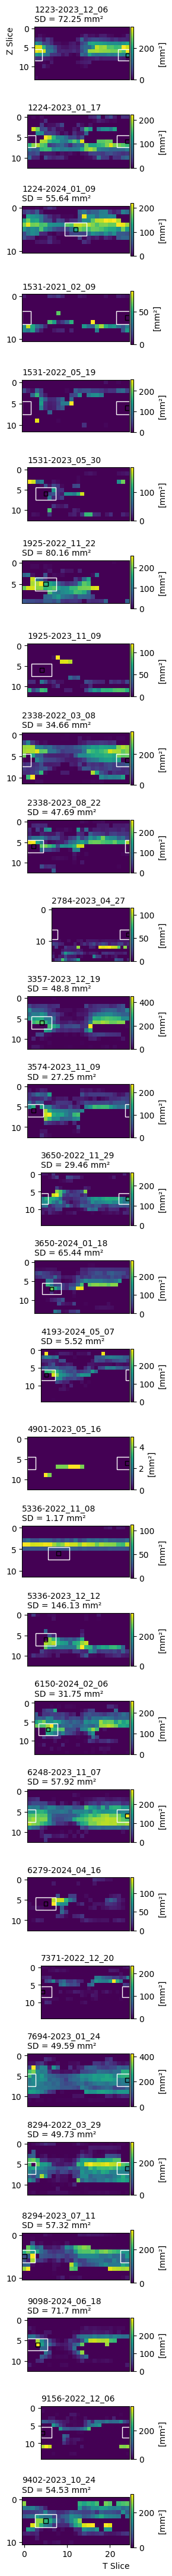

In [ ]:
from glob import glob
import nibabel as nib

from lc_functions import read_and_segment_dicoms
from lc_robustness import test_pm_robustness

template = nib.load(glob('../data/fazit/all_scans/*.nii.gz')[0]).get_fdata()
template = template[130:230, 210:310, :, :]

nifti_list = glob('../data/fazit/selected/*.nii.gz')
_, _, _, selected_slices = read_and_segment_dicoms(archive_list=nifti_list, template=template[:, :, 6, :], show_images=False, returns='areas', sort=False, crop_padding=6, return_slices=True);

print('selected_slices:', selected_slices)

test_pm_robustness(archive_list=nifti_list, template_array=template, selected_slices=selected_slices)

## Miscellaneous

In [ ]:
import scipy

# test normality of data using the Shapiro Wilk test
## p values > 0.05: normal distribution

normality = pd.DataFrame(columns=['p', 'normality'], index=['diam', 'area', 'num', 'pm/lv ratio'])

for key in ['diam', 'area', 'num', 'pm/lv ratio']:
    if key == 'diam':
        m = [i for k in ['hdiam1', 'hdiam2', 'vdiam1', 'vdiam2'] for i in measurements[k]]
    else:
        m = measurements[key]
    _, p = scipy.stats.shapiro(m)
    normality.loc[key, 'p'] = p
    if p < 0.05:
        normality.loc[key, 'normality'] = 'non-normal'
    else:
        normality.loc[key, 'normality'] = 'normal'

normality.to_csv('../results/normality.csv')